# SHSAT Test Results Preliminary EDA / Cleaning Notebook
[Return to project overview](final_project_overview.ipynb)

### Andrew Larimer, Deepak Nagaraj, Daniel Olmstead, Michael Winton (W207-4-Summer 2018 Final Project)

In this notebook, we will prepare the "training data" needed to run and validate our classifier.

## About the datasets

We use two datasets to create the training labels.

* [New York Times dataset](https://www.kaggle.com/willkoehrsen/nyc-shsat-test-results-2017)
* [New York Department of Education dataset](https://data.cityofnewyork.us/Education/2013-2018-Demographic-Snapshot-School/s52a-8aq6)

The first comes from a NYT article about lack of diversity in students who attend New York's specialized high schools.  For a number of New York schools, it gives us information about how many students took the SHSAT, and what the school's racial composition is.

The second dataset gives us information about how many students were enrolled in specific grades.

## Reading data

First, let us read the datasets.

In [1]:
import pandas as pd
import numpy as np
import re
import util

school_df = pd.read_csv('data_raw/2016_school_explorer.csv')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 5)

nyt_df = pd.read_csv('data_raw/nytdf.csv')
doe_school_df = pd.read_csv('data_raw/doe_demographic_snapshot_school.csv')

## NYTimes School Data

Let us have a first look at NYTimes data.

In [2]:
nyt_df.head()

,DBN,DataName,SchoolName1,SchoolName2,NumSHSATTestTakers,NumSpecializedOffers,OffersPerStudent,PctBlackOrHispanic
0,20K187,THE CHRISTA MCAULIFFE SCHOOL\I.S. 187,Intermediate School 187,The Christa McAuliffe School,251,205,75%,8%
1,21K239,MARK TWAIN I.S. 239 FOR THE GIFTED & TALENTED,Intermediate School 239,The Mark Twain Intermediate School for the Gif...,336,196,46%,13%
2,03M054,J.H.S. 054 BOOKER T. WASHINGTON,Junior High School 54,The Booker T. Washington School,257,150,53%,23%
3,15K051,M.S. 51 WILLIAM ALEXANDER,Midde School 51,The William Alexander School,280,122,33%,28%
4,02M312,NEW YORK CITY LAB MIDDLE SCHOOL FOR COLLABORAT...,NaN,New York City Lab Middle School for Collaborat...,163,113,62%,8%


### Cleanup

We will now use our utility functions to clean up some columns and column names for easier analysis.  After this, we will have another look.

In [3]:
# Remove percent and convert to float
percent_columns = [
    'OffersPerStudent',
    'PctBlackOrHispanic',
]
for col in percent_columns:
    nyt_df[col] = util.pct_to_number(nyt_df, col)
nyt_df.columns = [util.sanitize_column_names(c) for c in nyt_df.columns]

Let us now get an overview of the NYTimes data.

In [4]:
nyt_df.head()

,dbn,dataname,schoolname1,schoolname2,numshsattesttakers,numspecializedoffers,offersperstudent,pctblackorhispanic
0,20K187,THE CHRISTA MCAULIFFE SCHOOL\I.S. 187,Intermediate School 187,The Christa McAuliffe School,251,205,75,8
1,21K239,MARK TWAIN I.S. 239 FOR THE GIFTED & TALENTED,Intermediate School 239,The Mark Twain Intermediate School for the Gif...,336,196,46,13
2,03M054,J.H.S. 054 BOOKER T. WASHINGTON,Junior High School 54,The Booker T. Washington School,257,150,53,23
3,15K051,M.S. 51 WILLIAM ALEXANDER,Midde School 51,The William Alexander School,280,122,33,28
4,02M312,NEW YORK CITY LAB MIDDLE SCHOOL FOR COLLABORAT...,NaN,New York City Lab Middle School for Collaborat...,163,113,62,8


## DoE Demographics Data

We notice that the NYTimes dataset does not have school enrollment information.

We will look at the DoE data and clean it up as needed.

In [5]:
doe_school_df.head()

,DBN,School Name,Year,Total Enrollment,Grade PK (Half Day & Full Day),Grade K,Grade 1,Grade 2,Grade 3,Grade 4,Grade 5,Grade 6,Grade 7,Grade 8,Grade 9,Grade 10,Grade 11,Grade 12,# Female,% Female,# Male,% Male,# Asian,% Asian,# Black,% Black,# Hispanic,% Hispanic,# Multiple Race Categories Not Represented,% Multiple Race Categories Not Represented,# White,% White,# Students with Disabilities,% Students with Disabilities,# English Language Learners,% English Language Learners,# Poverty,% Poverty,Economic Need Index
0,01M015,P.S. 015 Roberto Clemente,2013-14,190,26,39,39,21,16,26,23,0,0,0,0,0,0,0,93,48.9%,97,51.1%,9,4.7%,72,37.9%,104,54.7%,2,1.1%,3,1.6%,65,34.2%,19,10%,171,90%,No Data
1,01M015,P.S. 015 Roberto Clemente,2014-15,183,18,27,47,31,19,17,24,0,0,0,0,0,0,0,84,45.9%,99,54.1%,8,4.4%,65,35.5%,107,58.5%,1,0.5%,2,1.1%,64,35%,17,9.3%,169,92.3%,93.5%
2,01M015,P.S. 015 Roberto Clemente,2015-16,176,14,32,33,39,23,17,18,0,0,0,0,0,0,0,83,47.2%,93,52.8%,9,5.1%,57,32.4%,105,59.7%,3,1.7%,2,1.1%,60,34.1%,16,9.1%,149,84.7%,89.6%
3,01M015,P.S. 015 Roberto Clemente,2016-17,178,17,28,33,27,31,24,18,0,0,0,0,0,0,0,83,46.6%,95,53.4%,14,7.9%,51,28.7%,105,59%,4,2.2%,4,2.2%,51,28.7%,12,6.7%,152,85.4%,89.2%
4,01M015,P.S. 015 Roberto Clemente,2017-18,190,17,28,32,33,23,31,26,0,0,0,0,0,0,0,99,52.1%,91,47.9%,20,10.5%,52,27.4%,110,57.9%,2,1.1%,6,3.2%,45,23.7%,8,4.2%,161,84.7%,89.0%


### Cleanup

In [6]:
doe_school_df.columns = [util.sanitize_column_names(c) for c in doe_school_df.columns]
doe_school_df.head()

,dbn,school_name,year,total_enrollment,grade_pk_half_day_&_full_day,grade_k,grade_1,grade_2,grade_3,grade_4,grade_5,grade_6,grade_7,grade_8,grade_9,grade_10,grade_11,grade_12,#_female,percent_female,#_male,percent_male,#_asian,percent_asian,#_black,percent_black,#_hispanic,percent_hispanic,#_multiple_race_categories_not_represented,percent_multiple_race_categories_not_represented,#_white,percent_white,#_students_with_disabilities,percent_students_with_disabilities,#_english_language_learners,percent_english_language_learners,#_poverty,percent_poverty,economic_need_index
0,01M015,P.S. 015 Roberto Clemente,2013-14,190,26,39,39,21,16,26,23,0,0,0,0,0,0,0,93,48.9%,97,51.1%,9,4.7%,72,37.9%,104,54.7%,2,1.1%,3,1.6%,65,34.2%,19,10%,171,90%,No Data
1,01M015,P.S. 015 Roberto Clemente,2014-15,183,18,27,47,31,19,17,24,0,0,0,0,0,0,0,84,45.9%,99,54.1%,8,4.4%,65,35.5%,107,58.5%,1,0.5%,2,1.1%,64,35%,17,9.3%,169,92.3%,93.5%
2,01M015,P.S. 015 Roberto Clemente,2015-16,176,14,32,33,39,23,17,18,0,0,0,0,0,0,0,83,47.2%,93,52.8%,9,5.1%,57,32.4%,105,59.7%,3,1.7%,2,1.1%,60,34.1%,16,9.1%,149,84.7%,89.6%
3,01M015,P.S. 015 Roberto Clemente,2016-17,178,17,28,33,27,31,24,18,0,0,0,0,0,0,0,83,46.6%,95,53.4%,14,7.9%,51,28.7%,105,59%,4,2.2%,4,2.2%,51,28.7%,12,6.7%,152,85.4%,89.2%
4,01M015,P.S. 015 Roberto Clemente,2017-18,190,17,28,32,33,23,31,26,0,0,0,0,0,0,0,99,52.1%,91,47.9%,20,10.5%,52,27.4%,110,57.9%,2,1.1%,6,3.2%,45,23.7%,8,4.2%,161,84.7%,89.0%


### Filtering data

We will filter it down to the year we are interested in (2017-18) based on the above SHSAT data, and do some cleanup.  We look at 2017-18 because the test is at the very beginning of the year:

> Registration is September 7-October 12, 2017... In 2017, tests were given October 21, 22; October 29, and November 4.

We can also filter information into Grade 8/9 enrollments:

> All students in grades eight and nine who are current New York City residents are eligible. [Source](https://www.schools.nyc.gov/school-life/learning/testing/specialized-high-school-admissions-test)

In [7]:
shsat_eligible_class_size_df = doe_school_df \
    .query("year == '2017-18'") \
    [['dbn', 'grade_7', 'grade_8', 'grade_9']]
shsat_eligible_class_size_df.head()

,dbn,grade_7,grade_8,grade_9
4,01M015,0,0,0
9,01M019,0,0,0
14,01M020,0,0,0
19,01M034,41,58,0
24,01M063,0,0,0


### Combining data
We will now combine the enrollment data with the NYTimes data.

In [8]:
combined_df = nyt_df.merge(shsat_eligible_class_size_df, on='dbn', how='left')
combined_df.head()

,dbn,dataname,schoolname1,schoolname2,numshsattesttakers,numspecializedoffers,offersperstudent,pctblackorhispanic,grade_7,grade_8,grade_9
0,20K187,THE CHRISTA MCAULIFFE SCHOOL\I.S. 187,Intermediate School 187,The Christa McAuliffe School,251,205,75,8,266,274,0
1,21K239,MARK TWAIN I.S. 239 FOR THE GIFTED & TALENTED,Intermediate School 239,The Mark Twain Intermediate School for the Gif...,336,196,46,13,422,429,0
2,03M054,J.H.S. 054 BOOKER T. WASHINGTON,Junior High School 54,The Booker T. Washington School,257,150,53,23,295,282,0
3,15K051,M.S. 51 WILLIAM ALEXANDER,Midde School 51,The William Alexander School,280,122,33,28,379,369,0
4,02M312,NEW YORK CITY LAB MIDDLE SCHOOL FOR COLLABORAT...,NaN,New York City Lab Middle School for Collaborat...,163,113,62,8,177,181,0


Let us run some quick sanity checks.

In [9]:
# using the fact that np.nan != np.nan
display(combined_df.query('grade_8 != grade_8 | grade_9 != grade_9'))
display(combined_df.query('numshsattesttakers > grade_8 + grade_9'))

,dbn,dataname,schoolname1,schoolname2,numshsattesttakers,numspecializedoffers,offersperstudent,pctblackorhispanic,grade_7,grade_8,grade_9


,dbn,dataname,schoolname1,schoolname2,numshsattesttakers,numspecializedoffers,offersperstudent,pctblackorhispanic,grade_7,grade_8,grade_9


Looks good.  There are no invalid values or empty values.

### Percent test takers

We will define our outcome variable as the fraction of test takers, for each school.  i.e., PASSNYC would want to design its model so that the fraction of test takers is high for each school.  Similarly, we would want to emulate schools that have a high fraction of test takers.

Let us add a column for fraction of test takers and look at its distribution.

In [10]:
combined_df['pct_test_takers'] = (combined_df['numshsattesttakers'] * 100 \
                / (combined_df['grade_8'] + combined_df['grade_9'])).astype('int')
combined_df[['dataname', 'pct_test_takers']].head()

,dataname,pct_test_takers
0,THE CHRISTA MCAULIFFE SCHOOL\I.S. 187,91
1,MARK TWAIN I.S. 239 FOR THE GIFTED & TALENTED,78
2,J.H.S. 054 BOOKER T. WASHINGTON,91
3,M.S. 51 WILLIAM ALEXANDER,75
4,NEW YORK CITY LAB MIDDLE SCHOOL FOR COLLABORAT...,90


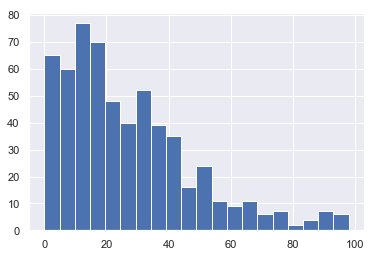

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

plt.hist(combined_df['pct_test_takers'], bins=20)
plt.show()

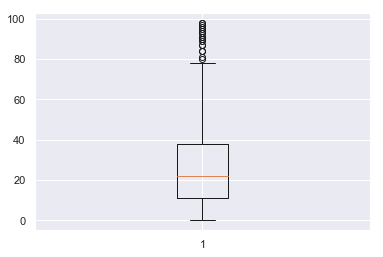

In [12]:
plt.boxplot(combined_df['pct_test_takers'])
plt.show()

In [13]:
# calculate 75th percentile (correponding to top of box plot)
pct75 = np.percentile(combined_df['pct_test_takers'], q=75)
pct75

38.0

### Defining success label

From the plots above, it looks like we have a sharp drop at around 40%.  Calculating the 75th percentile correponding to the top of the box in the blox plot, we see it's actually 38.0.  We will use that as a threshhold, and label any school that has >38.0% registrations (ie. 75th percentile) as "successful".

Let us also have a look at how the distribution of offers per student is spread out.

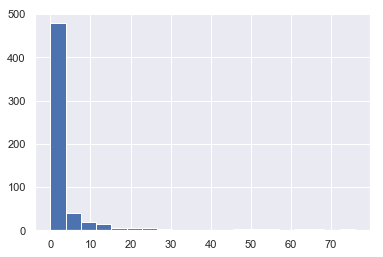

In [14]:
plt.hist(combined_df['offersperstudent'], bins=20)
plt.show()

In [15]:
combined_df['high_registrations'] = (combined_df['pct_test_takers'] > pct75).astype('int')
combined_df.head()

,dbn,dataname,schoolname1,schoolname2,numshsattesttakers,numspecializedoffers,offersperstudent,pctblackorhispanic,grade_7,grade_8,grade_9,pct_test_takers,high_registrations
0,20K187,THE CHRISTA MCAULIFFE SCHOOL\I.S. 187,Intermediate School 187,The Christa McAuliffe School,251,205,75,8,266,274,0,91,1
1,21K239,MARK TWAIN I.S. 239 FOR THE GIFTED & TALENTED,Intermediate School 239,The Mark Twain Intermediate School for the Gif...,336,196,46,13,422,429,0,78,1
2,03M054,J.H.S. 054 BOOKER T. WASHINGTON,Junior High School 54,The Booker T. Washington School,257,150,53,23,295,282,0,91,1
3,15K051,M.S. 51 WILLIAM ALEXANDER,Midde School 51,The William Alexander School,280,122,33,28,379,369,0,75,1
4,02M312,NEW YORK CITY LAB MIDDLE SCHOOL FOR COLLABORAT...,NaN,New York City Lab Middle School for Collaborat...,163,113,62,8,177,181,0,90,1


In [16]:
out_df = combined_df[['dbn', 'grade_7', 'numshsattesttakers', 'offersperstudent', 'pct_test_takers', 'high_registrations']]
# manually add underscores to ccolumn names for consistency
out_df.columns = ['dbn', 'grade_7_enrollment', 'num_shsat_test_takers', 'offers_per_student', 'pct_test_takers', 'high_registrations']
# check final shape (rows = number of schools)
out_df.shape

(589, 6)

We will save this csv file out.

In [17]:
out_df.to_csv('data_cleaned/cleaned_shsat_outcomes.csv', index=False)